We attempt circuit discovery of the most important forbidden word downweighting circuits.

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import prompt_data, utils, ablation

### Load model

In [4]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
# tl_model.requires_grad_(False)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Load facts and develop prompt

In [5]:
irrelevant_words = ["apple", "river", "car", "dog", "house", "tree", "book"]

df_raw = pd.read_csv("../../data/facts.csv")
assert set(df_raw.answer) & set(irrelevant_words) == set()
df_raw

,question,answer,type
0,Tom Brady plays the sport of,football,sport
1,LeBron James plays the sport of,basketball,sport
2,Lionel Messi plays the sport of,football,sport
3,Serena Williams plays the sport of,tennis,sport
4,Michael Phelps competes in the sport of,swimming,sport
...,...,...,...
186,Mick Mars plays the,guitar,instrument
187,John Densmore plays the,drums,instrument
188,Jack Bruce plays the,bass,instrument
189,Lars Ulrich plays the,drums,instrument


In [6]:
def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""


df_raw["fb_word"] = "apple"
df_raw["prompt_nc"] = [
    get_dontsay_prompt(q, fw) for q, fw in zip(df_raw.question, df_raw.fb_word)
]
df_raw["prompt_c"] = [
    get_dontsay_prompt(q, answer)
    for q, answer in zip(df_raw.question, df_raw.answer)
]


idx = 0
tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate([df_raw.prompt_nc[idx], df_raw.prompt_c[idx]]):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
    )
    print() if i == 0 else None

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 26.48 Prob: 99.67% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 20.00 Prob:  0.15% Tokens: (18322) |FO|OT|B|ALL|</s>|
Rank 2. Logit: 19.85 Prob:  0.13% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 17.54 Prob:  0.01% Tokens: (13440) |Foot|ball|</s>|
Rank 4. Logit: 17.15 Prob:  0.01% Tokens: (25167) |NFL|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 17.79 Prob: 63.15% Tokens: (23185) |Baseball|</s>|
Rank 1. Logit: 16.07 Prob: 11.32% Tokens: (21850) |Basketball|</s>|
Rank 2. Logit: 15.47 Prob:  6.22% Tokens: (  376) |"|B|asketball|"|</s>|
Rank 3. Logit: 15.30 Prob:  5.27% Tokens: (18585) |Sure|!|Tom|Br|ady|plays|...|(|p|aus|es|for|

In [7]:
metrics = []
for idx in tqdm(range(len(df_raw))):
    prompt_nc = df_raw.prompt_nc[idx]
    prompt_c = df_raw.prompt_c[idx]

    with torch.no_grad():
        logits_nc = tl_model.forward(prompt_nc)[0, -1]
        logits_c = tl_model.forward(prompt_c)[0, -1]

    top_tok_nc = logits_nc.argmax().item()
    top_tok_c = logits_c.argmax().item()

    log_odds_nc = logits_nc.softmax(dim=-1)[top_tok_nc].logit()
    log_odds_c = logits_c.softmax(dim=-1)[top_tok_nc].logit()
    log_bf_fb = log_odds_c - log_odds_nc

    metrics.append(
        dict(
            top_tok_nc=top_tok_nc,
            top_tok_c=top_tok_c,
            logits_c=logits_c.detach().cpu().numpy(),
            logits_nc=logits_nc.detach().cpu().numpy(),
            log_bf_fb=log_bf_fb.item(),
            top_str_nc=tl_model.to_string(top_tok_nc),
            top_str_c=tl_model.to_string(top_tok_c),
        )
    )

df_raw = df_raw.assign(**pd.DataFrame(metrics))

  0%|          | 0/191 [00:00<?, ?it/s]

In [8]:
df_raw["correct_nc"] = [
    answer.lower().startswith(top_str_nc.lower())
    for top_str_nc, answer in zip(df_raw.top_str_nc, df_raw.answer)
]
print(f"# correct: {df_raw.correct_nc.sum()} / {len(df_raw)}")
df = df_raw.query("correct_nc").reset_index(drop=True)
df_raw.query("~correct_nc")[["question", "answer", "top_str_nc"]]

# correct: 186 / 191


,question,answer,top_str_nc
128,The element with atomic symbol Kr is,krypton,Pot
134,The element with atomic symbol Pm is,promethium,Pl
170,Chet Baker plays the,trumpet,Jazz
171,Lee Morgan plays the,trumpet,Jazz
188,Jack Bruce plays the,bass,Gu


### Analyze effect of forbidding the correct answer

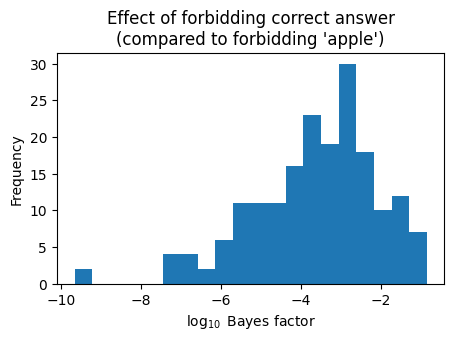

In [9]:
plt.figure(figsize=(5,3))
plt.title("Effect of forbidding correct answer\n(compared to forbidding 'apple')")
plt.hist(df.log_bf_fb / np.log(10), bins=20)
plt.xlabel("$\log_{10}$ Bayes factor")
plt.ylabel("Frequency")
plt.show()

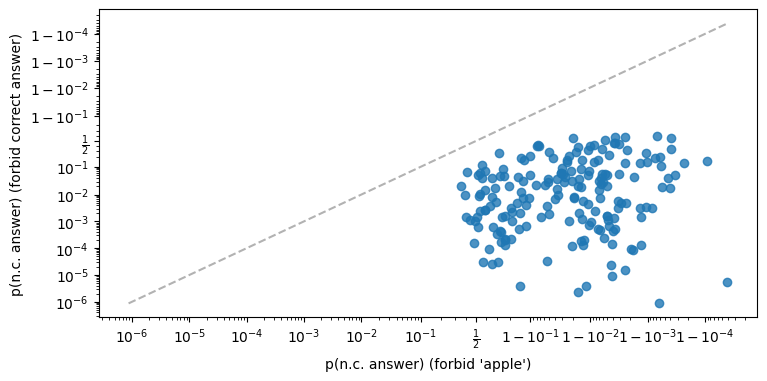

In [10]:
logits_c = torch.tensor(np.stack(df.logits_c))
logits_nc = torch.tensor(np.stack(df.logits_nc))
top_tok_nc = torch.tensor(df.top_tok_nc)

prob_c = logits_c.softmax(dim=-1)[range(len(top_tok_nc)), top_tok_nc].numpy()
prob_nc = logits_nc.softmax(dim=-1)[range(len(top_tok_nc)), top_tok_nc].numpy()

plt.figure(figsize=(8.5, 4))
plt.scatter(prob_nc, prob_c, alpha=0.8)
utils.plot_x_eq_y_line(
    prob_nc,
    prob_c,
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    label="y=x",
)
plt.xscale("logit")
plt.yscale("logit")
plt.xlabel("p(n.c. answer) (forbid 'apple')")
plt.ylabel("p(n.c. answer) (forbid correct answer)")
plt.show()

### Components contributions via independent ablations

In [49]:
LABELS: list[str] | None = None
metrics = []
for idx in tqdm(range(len(df))):
    prompt_c = df.prompt_c[idx]
    prompt_nc = df.prompt_nc[idx]
    tok = df.top_tok_nc[idx]

    with torch.no_grad():
        pd_c = prompt_data.PromptData.get_data(prompt_c, tl_model)
        pd_nc = prompt_data.PromptData.get_data(prompt_nc, tl_model)

    res_c_norm = torch.linalg.vector_norm(pd_c.cache["resid_post", -1][-1])
    res_nc_norm = torch.linalg.vector_norm(pd_nc.cache["resid_post", -1][-1])

    ld_c_nc = prompt_data.get_direct_effect_logits(
        tl_model=tl_model, pd=pd_c, ablation_cache=pd_nc.cache
    )
    ld_nc_c = prompt_data.get_direct_effect_logits(
        tl_model=tl_model, pd=pd_nc, ablation_cache=pd_c.cache
    )

    def get_log_bf(ld: prompt_data.LogitData):
        return (
            ld.get_logits_and_labels()[0].softmax(dim=-1)[:, tok].logit()
            - ld.pd.final_logits.softmax(dim=-1)[tok].logit()
        )

    if idx == 0:
        LABELS = ld_c_nc.get_labels()
    metrics.append(
        dict(
            res_c_norm=res_c_norm.item(),
            res_nc_norm=res_nc_norm.item(),
            comp_log_bf_c_nc=get_log_bf(ld_c_nc).detach().cpu().numpy(),
            comp_log_bf_nc_c=get_log_bf(ld_nc_c).detach().cpu().numpy(),
        )
    )

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/186 [00:00<?, ?it/s]

In [50]:
utils.plot_head_data(
    lines=[
        (f"base: c; patch: nc", df.comp_log_bf_c_nc.mean() / np.log(10), LABELS),
        (f"base: nc; patch: c", df.comp_log_bf_nc_c.mean() / np.log(10), LABELS),
    ],
    spacing=32,
    title="Attribution patching, base: non-competing, patch: competing",
    yaxis_title="log_10 Bayes factor",
    xaxis_title="Component",
    height=420,
    width=800,
).show()

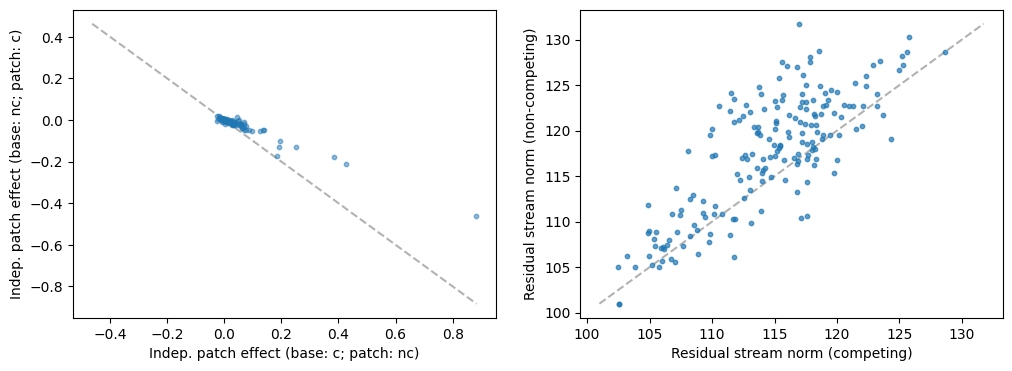

In [55]:
xs = np.stack(df.comp_log_bf_c_nc.mean()).flatten() / np.log(10)
ys = np.stack(df.comp_log_bf_nc_c.mean()).flatten() / np.log(10)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(xs, ys, alpha=0.5, s=10)
utils.plot_x_eq_y_line(
    xs,
    ys,
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    pos=False,
)
plt.xlabel("Indep. patch effect (base: c; patch: nc)")
plt.ylabel("Indep. patch effect (base: nc; patch: c)")

plt.subplot(1, 2, 2)
plt.scatter(df.res_c_norm, df.res_nc_norm, alpha=0.7, s=10)
utils.plot_x_eq_y_line(
    df.res_c_norm,
    df.res_nc_norm,
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
)
plt.xlabel("Residual stream norm (competing)")
plt.ylabel("Residual stream norm (non-competing)")

plt.show()

### Most important components

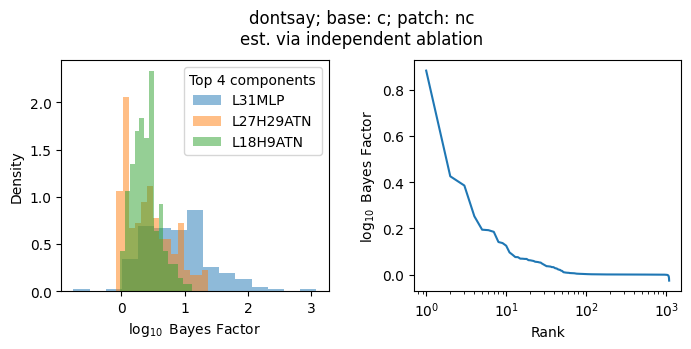

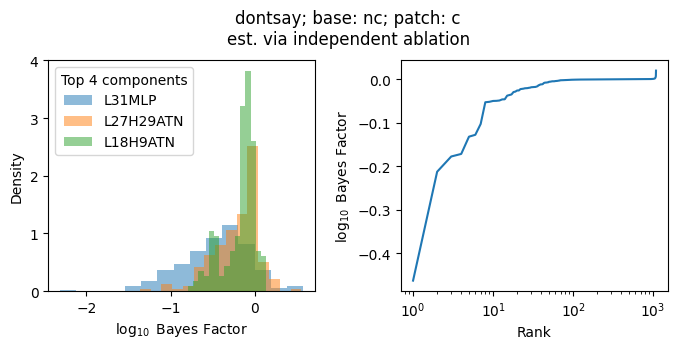

In [66]:
top_k = 3
for log_bfs, descrip, reverse in [
    (np.stack(df.comp_log_bf_c_nc), "base: c; patch: nc", True),
    (np.stack(df.comp_log_bf_nc_c), "base: nc; patch: c", False),
]:
    log_bf_means = log_bfs.mean(axis=0)
    log_bf_x_label = sorted(
        list(zip(log_bf_means, LABELS)), reverse=reverse
    )

    plt.figure(figsize=(8, 3))
    plt.subplots_adjust(wspace=0.32)
    plt.suptitle(
        f"dontsay; {descrip}"
        + "\n"
        + "est. via independent ablation",
        y=1.05,
    )

    plt.subplot(1, 2, 1)
    for _, label in log_bf_x_label[:top_k]:
        idx = LABELS.index(label)
        plt.hist(
            log_bfs[:, idx] / np.log(10),
            label=label,
            bins=15,
            density=True,
            alpha=0.5,
        )

    plt.xlabel("$\log_{10}$ Bayes Factor")
    plt.ylabel("Density")
    plt.legend(title="Top 4 components")

    plt.subplot(1, 2, 2)
    plt.plot(
        np.arange(len(log_bf_means)) + 1,
        np.sort(log_bf_means)[:: -1 if reverse else 1] / np.log(10),
    )
    plt.xscale("log")
    plt.xlabel("Rank")
    plt.ylabel("$\log_{10}$ Bayes Factor")

    plt.show()

### TODO: Determine how many terminal nodes we need to ablate to recover most of the bayes factor.